In [1]:
# import package
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from zipfile import ZipFile
import os
import math
from datetime import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load data
def load_data(path, file_name, dtype=None, converters=None):
    """
    read zip file into the dataframe.

    Params:
        (str) path - the directory stores those files.
        (str) file_name - name of the file that is compressed in the zipfile
        (Dict or None) dtype - specify data type of the dataframe
        (Dict or None) converters - dict stores the convert function
    Result:
        (DataFrame) df - load the data into the dataframe
    """
    with ZipFile(path + file_name + ".zip") as zip_file:
        with zip_file.open(file_name) as file:
            df = pd.read_csv(file, dtype=dtype, converters=converters)
    
    return df

In [3]:
train_data = load_data("../data/rossmann_store_sales/", "train.csv", 
                       dtype={"StateHoliday":"category",
                             "SchoolHoliday":"category",
                             "Promo":"category",
                             "Promo2":"category"},
                       converters={"Date":lambda x: pd.to_datetime(x, errors="raise")})
store_data = load_data("../data/rossmann_store_sales/", "store.csv")

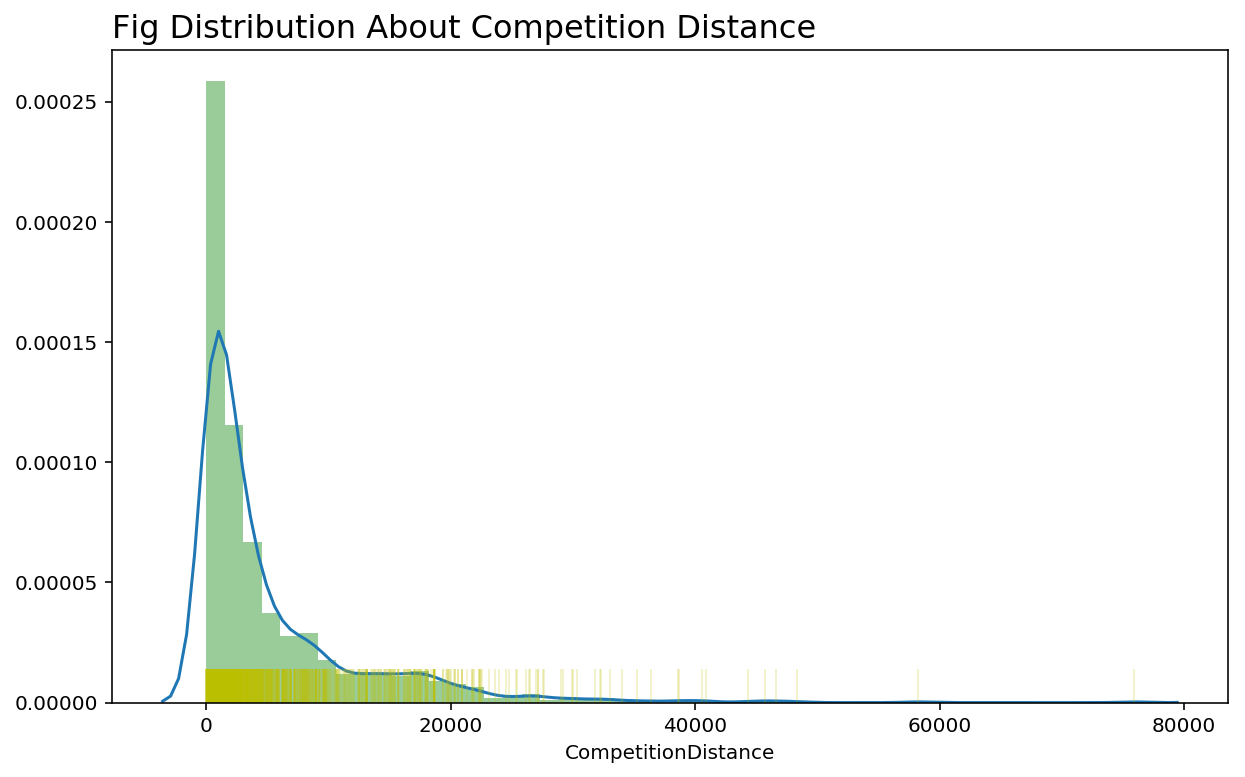

In [4]:
plt.figure(figsize=(10, 6))
sns.distplot(store_data["CompetitionDistance"].dropna(),
             rug=True, rug_kws={"alpha":0.2, "color":"y"},
            hist_kws={"color":"g"})
plt.title("Fig Distribution About Competition Distance", loc="left", fontsize=16)
plt.show()

In [5]:
# fill the missing value about the competition distance
store_data["CompetitionDistance"].fillna(store_data["CompetitionDistance"].median(), inplace=True)

In [6]:
# concat the CompetitionOpenSinceYear and the CompetitionOpenSinceMonth to create a new variable CompetitionOpenDate
CompetitionOpenDate = []
for year, month in zip(store_data["CompetitionOpenSinceYear"], store_data["CompetitionOpenSinceMonth"]):
    if (not np.isnan(year)) and (not np.isnan(month)):
        CompetitionOpenDate.append(str(int(year)) + "/" + str(int(month)) + "/01")
    else:
        CompetitionOpenDate.append(np.nan)

store_data["CompetitionOpenDate"] = pd.to_datetime(pd.Series(CompetitionOpenDate))

In [7]:
# create the date time about the promo2, the weekday choose monday
Promo2Date = []
for year, week in zip(store_data["Promo2SinceYear"], store_data["Promo2SinceWeek"]):
    if (not np.isnan(year)) & (not np.isnan(week)):
        Promo2Date.append(datetime.strptime("{0:04} {1:02} 1".format(int(year), int(week)), "%G %V %u"))
    else:
        Promo2Date.append(np.nan)

store_data["Promo2StartDate"] = pd.Series(Promo2Date)

In [8]:
# split the promointerval value and create the new features in the store data
promo_interval_split = store_data["PromoInterval"].str.split(",", expand=True)
promo_interval_split.columns = ["PromoInterval1", "PromoInterval2", "PromoInterval3", "PromoInterval4"]
store_data = pd.concat([store_data, promo_interval_split],axis=1, join="inner")

In [9]:
# 创建了新的列名称，分别是 OpenYear 和 OpenMonth, TempDate，SalesPerCustomers,CompetitionOpenMonths,Promo2OpenMonths
train_data["OpenYear"] = train_data["Date"].dt.year
train_data["OpenMonth"] = train_data["Date"].dt.month
train_data["OpenWeekOfYear"] = train_data["Date"].dt.weekofyear

train_data["TemDate"] = train_data["Date"].dt.year.apply(str) + \
    train_data["Date"].dt.month.apply(lambda x: "/{0:02d}/01".format(x))

train_data["SalesPerCustomers"] = train_data["Sales"] / train_data["Customers"]

In [10]:
# merge the sales data and the store data
raw_data = pd.merge(train_data, store_data, how="left", on="Store")

In [11]:
raw_data["CompetitionOpenMonths"] = (raw_data["OpenYear"] - raw_data["CompetitionOpenSinceYear"]) * 12 + \
    raw_data["OpenMonth"] - raw_data["CompetitionOpenSinceMonth"]

raw_data["Promo2OpenMonths"] = (raw_data["OpenYear"] - raw_data["Promo2SinceYear"]) * 12 + \
    (raw_data["OpenWeekOfYear"] - raw_data["Promo2SinceWeek"]) / 4

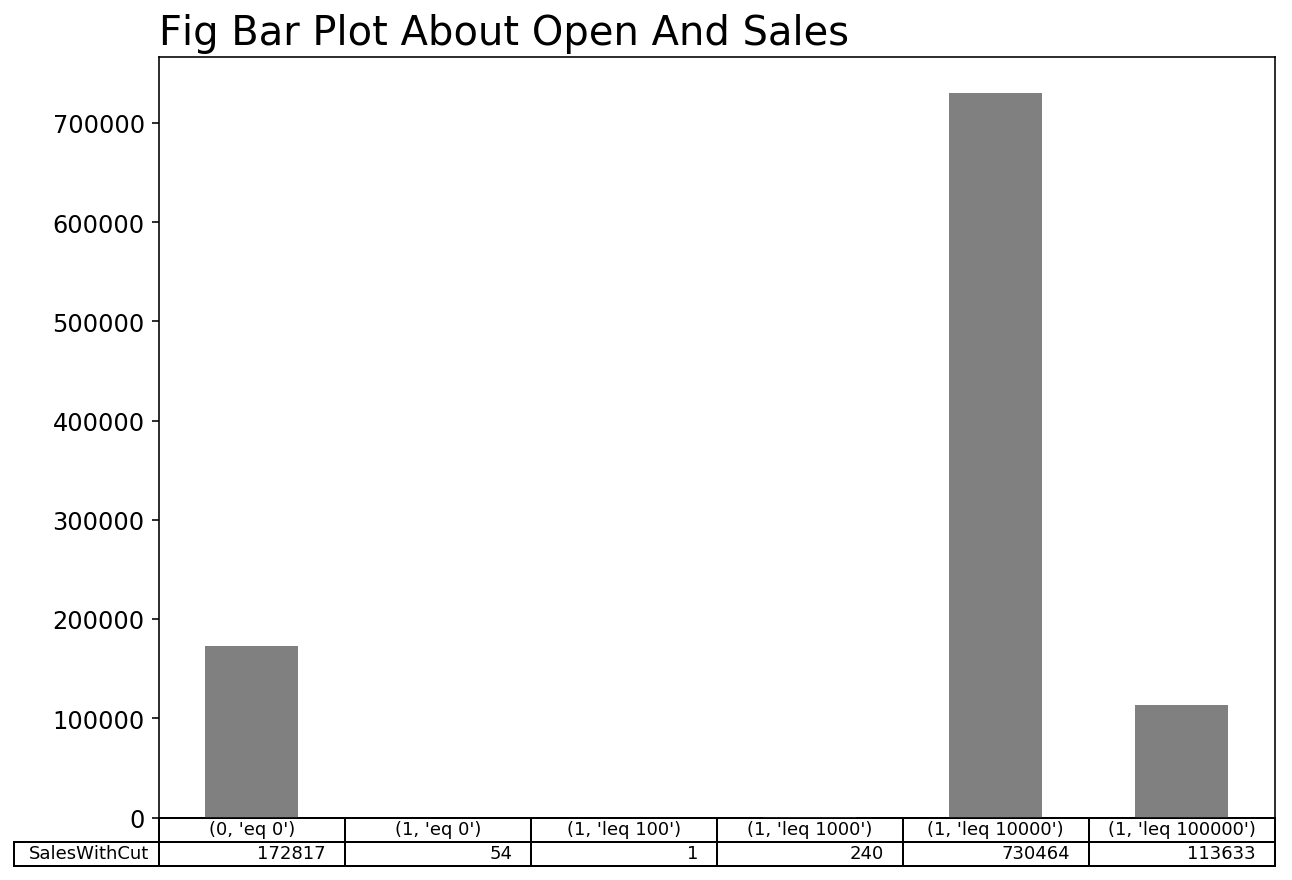

In [12]:
raw_data["SalesWithCut"] = pd.cut(raw_data["Sales"], [-0.1, 0, 100, 1000, 10000, 100000], 
       labels=["eq 0", "leq 100", "leq 1000", "leq 10000", "leq 100000"])
raw_data.groupby(["Open", "SalesWithCut"])["SalesWithCut"].count()

# display the bar plot about the open with the sales
ax = raw_data.groupby(["Open", "SalesWithCut"])["SalesWithCut"].count().plot(kind="bar", figsize=(10,7), table=True, fontsize=12, color="grey")
ax.set_title("Fig Bar Plot About Open And Sales", loc="left", fontsize=20)
ax.get_xaxis().set_visible(False)

## Explore Data

In [13]:
# copy data
data = raw_data.copy()

In [14]:
# explore the data
for i, column in enumerate(data):
    print(i, column)

0 Store
1 DayOfWeek
2 Date
3 Sales
4 Customers
5 Open
6 Promo
7 StateHoliday
8 SchoolHoliday
9 OpenYear
10 OpenMonth
11 OpenWeekOfYear
12 TemDate
13 SalesPerCustomers
14 StoreType
15 Assortment
16 CompetitionDistance
17 CompetitionOpenSinceMonth
18 CompetitionOpenSinceYear
19 Promo2
20 Promo2SinceWeek
21 Promo2SinceYear
22 PromoInterval
23 CompetitionOpenDate
24 Promo2StartDate
25 PromoInterval1
26 PromoInterval2
27 PromoInterval3
28 PromoInterval4
29 CompetitionOpenMonths
30 Promo2OpenMonths
31 SalesWithCut


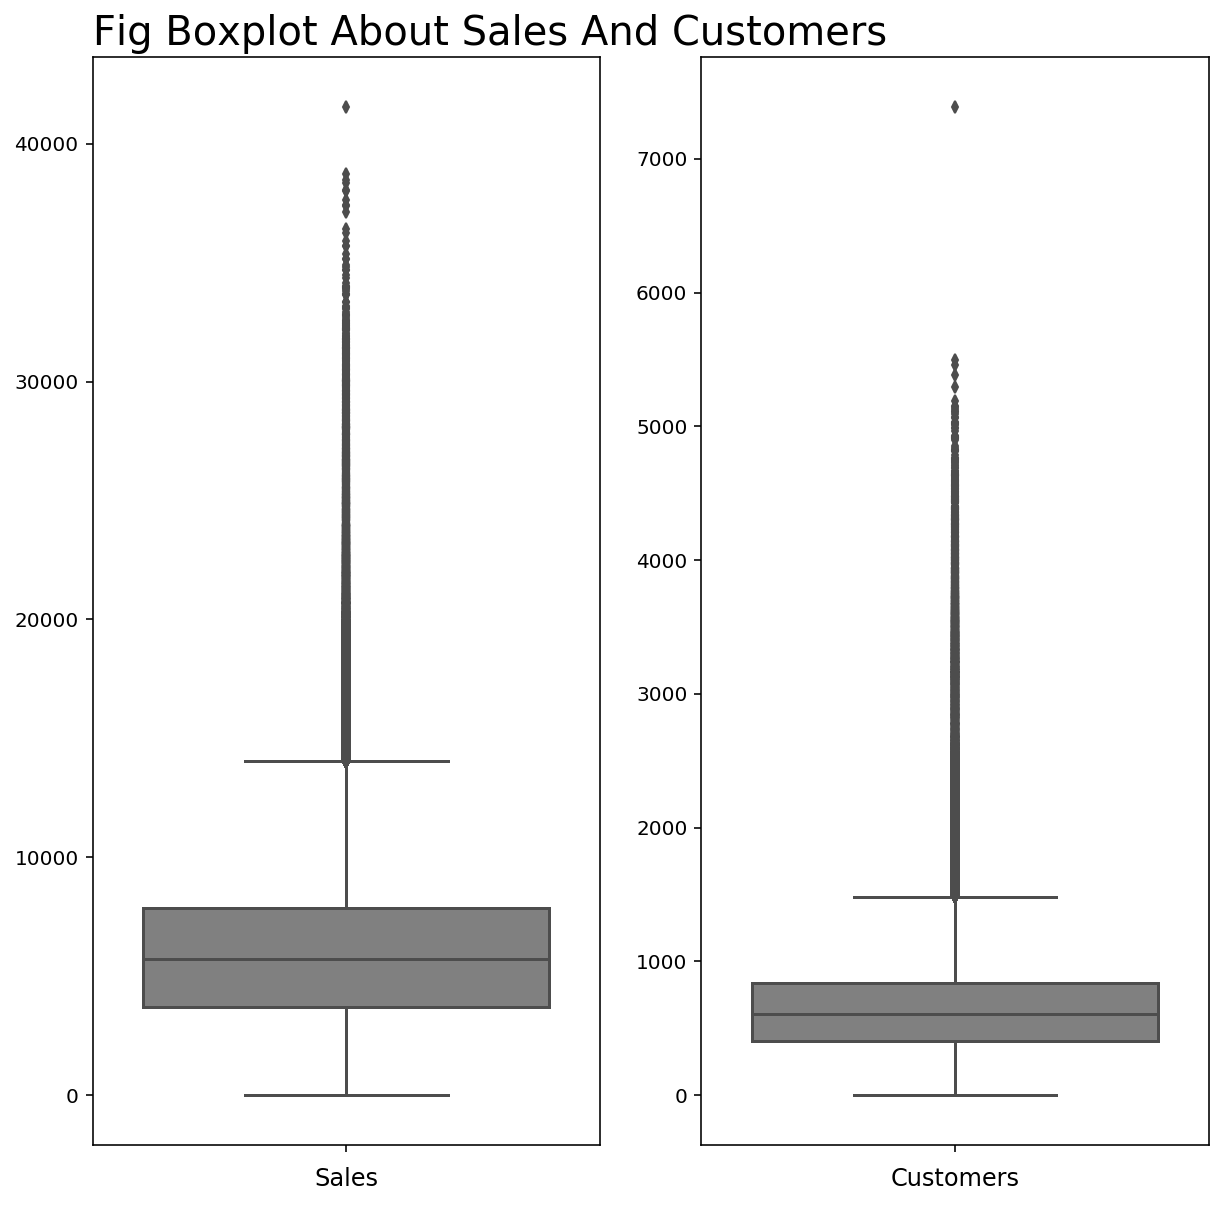

In [15]:
plt.subplots(122, figsize=(10, 10))
plt.subplot(121)
sns.boxplot(data["Sales"], color="grey", fliersize=4, orient="v")
plt.ylabel("")
plt.xlabel("Sales", fontsize=12)
plt.title("Fig Boxplot About Sales And Customers", loc="left", fontsize=20)

plt.subplot(122)
sns.boxplot(data["Customers"], color="grey", fliersize=4, orient="v")
plt.ylabel("")
plt.xlabel("Customers", fontsize=12)

plt.show()

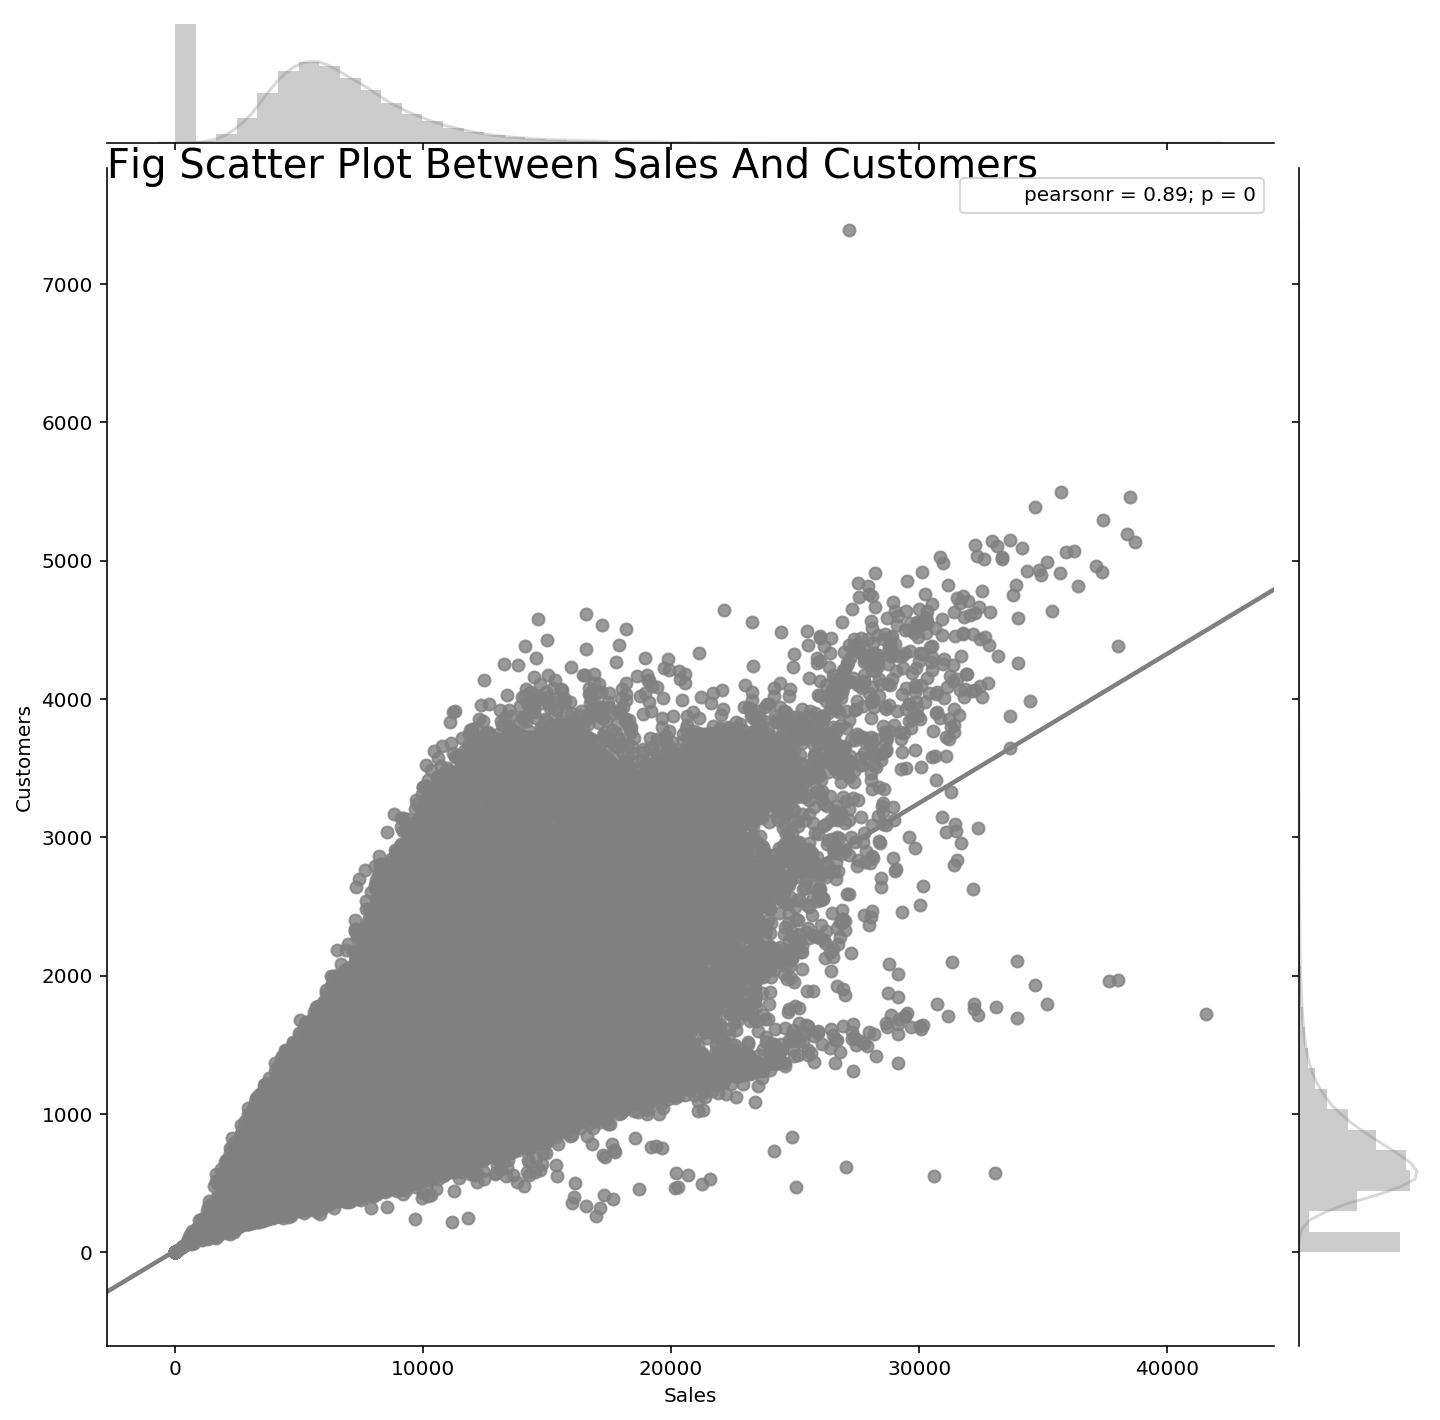

In [16]:
sns.jointplot(x="Sales", y="Customers", data=data,size=10, ratio=8, color=(0.5, 0.5, 0.5, 0.3), kind="reg")
plt.title("Fig Scatter Plot Between Sales And Customers", loc="left", fontsize=20, pad=-5)
plt.show()

In [17]:
missing_count = pd.DataFrame(data.isnull().sum(),columns=["Count"])

In [18]:
missing_count

,Count
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
OpenYear,0


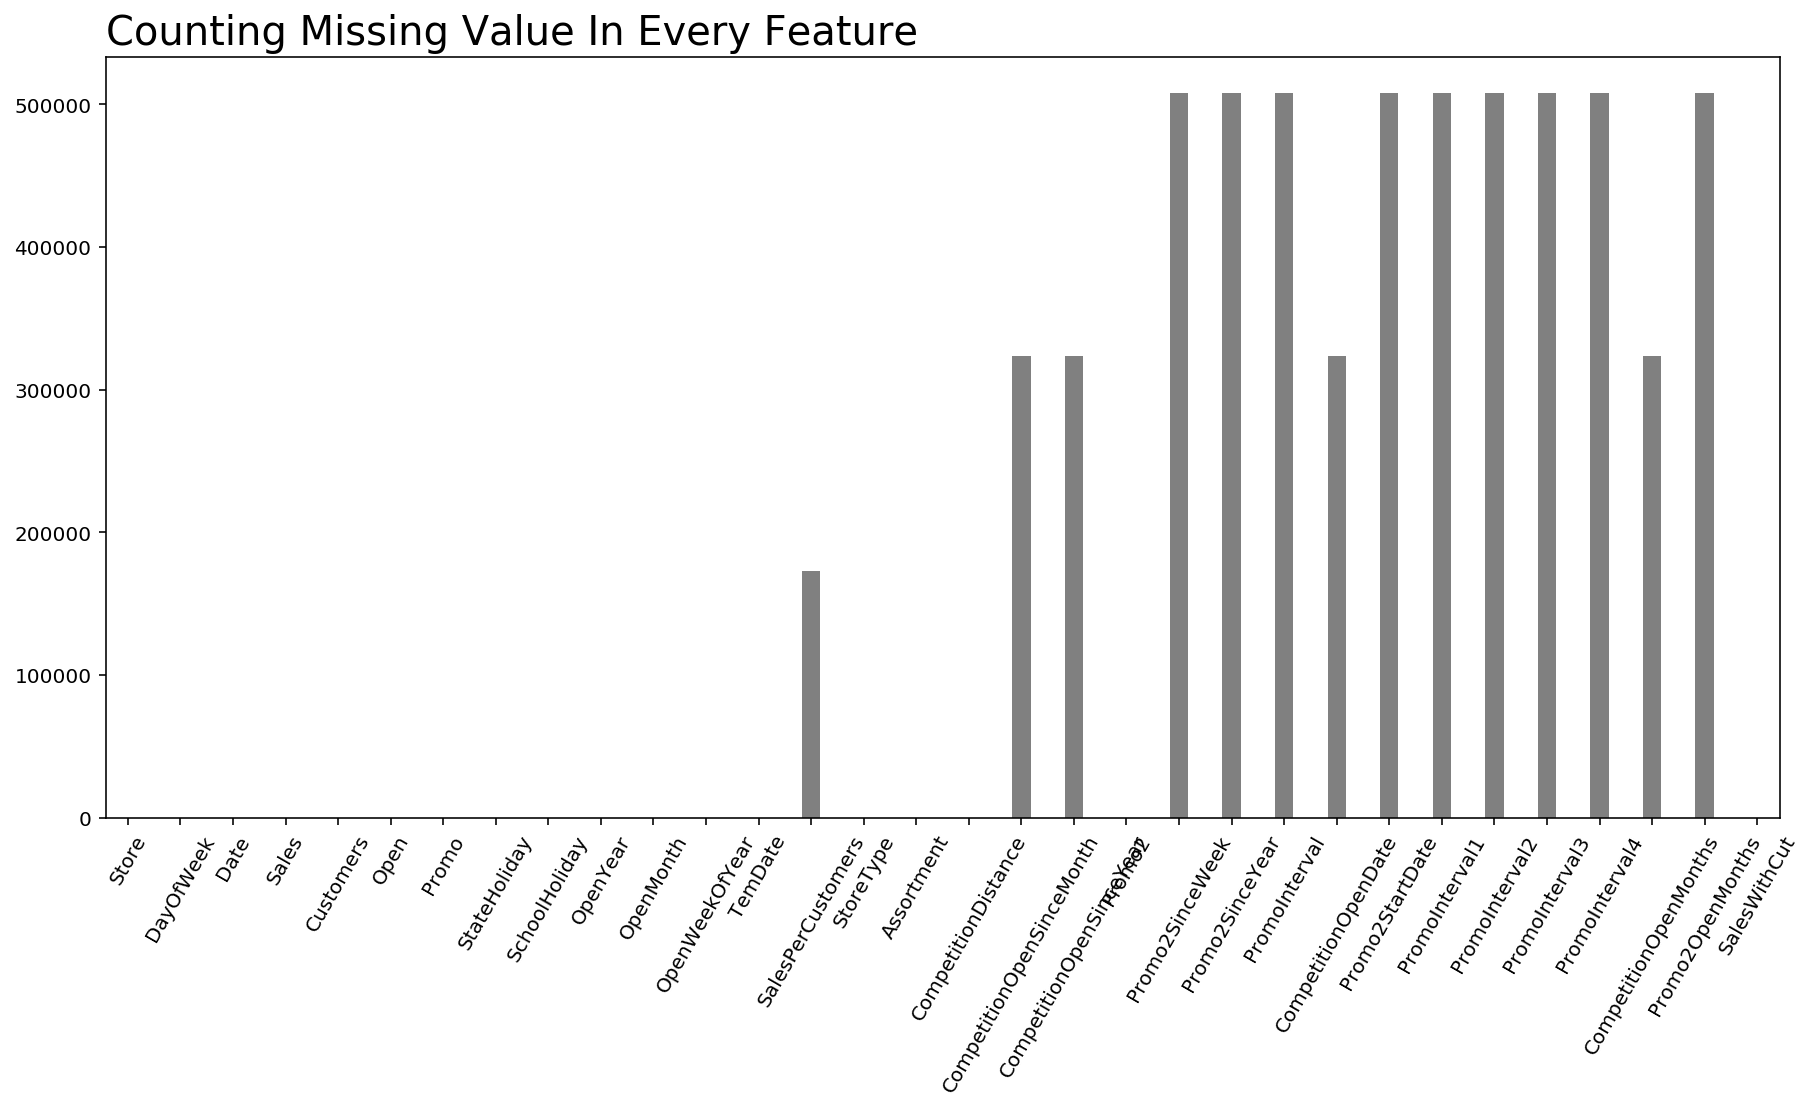

In [19]:
missing_count.plot(kind="bar", figsize=(15, 7), rot=60, legend=False, width=0.35, facecolor="grey")
plt.title("Counting Missing Value In Every Feature", loc="left", fontsize=20)
plt.show()

In [20]:
data.sort_values(by="Date").head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,OpenYear,...,PromoInterval,CompetitionOpenDate,Promo2StartDate,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4,CompetitionOpenMonths,Promo2OpenMonths,SalesWithCut
1017208,1115,2,2013-01-01,0,0,0,0,a,1,2013,...,"Mar,Jun,Sept,Dec",NaT,2012-05-28,Mar,Jun,Sept,Dec,NaN,6.75,eq 0
1016473,379,2,2013-01-01,0,0,0,0,a,1,2013,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,eq 0


In [21]:
# group by date to caculate the data
sales_by_date = data.groupby(["Date"], as_index=False)["Sales"].sum()

In [22]:
sales_by_date["rollingsum"] = sales_by_date["Sales"].rolling(7).mean()

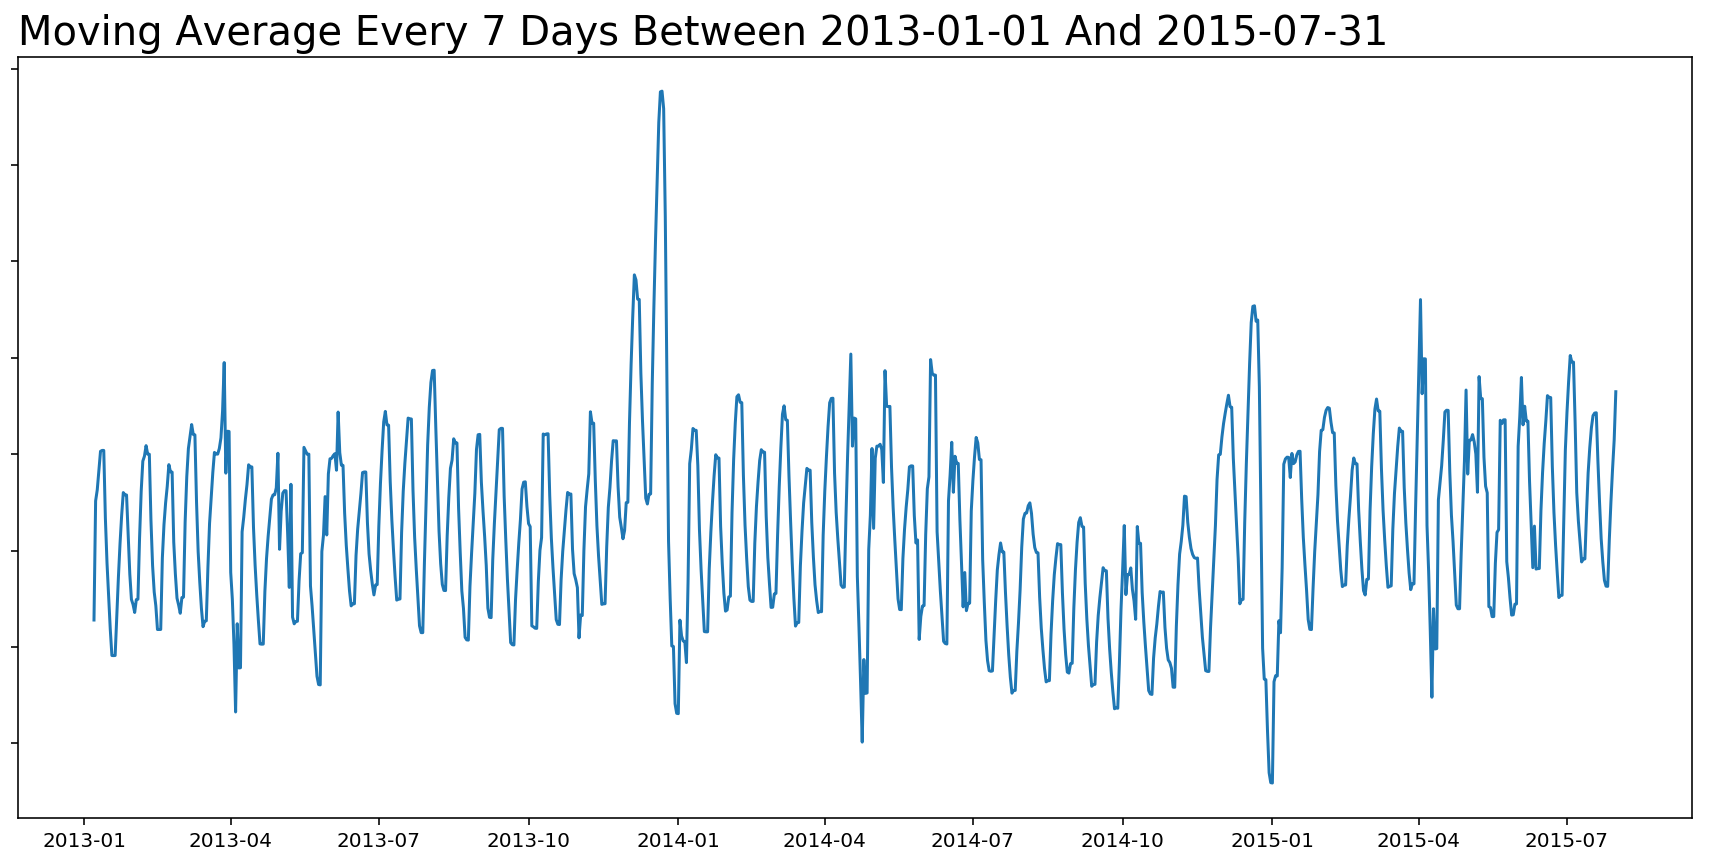

In [23]:
plt.figure(figsize=(15,7))
plt.plot(sales_by_date["Date"].get_values(), sales_by_date["rollingsum"].get_values())
plt.tick_params(labelleft=False)
plt.title("Moving Average Every 7 Days Between %s And %s" % (sales_by_date["Date"].min().date(), sales_by_date["Date"].max().date()),
         loc="left", fontsize=20)

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()

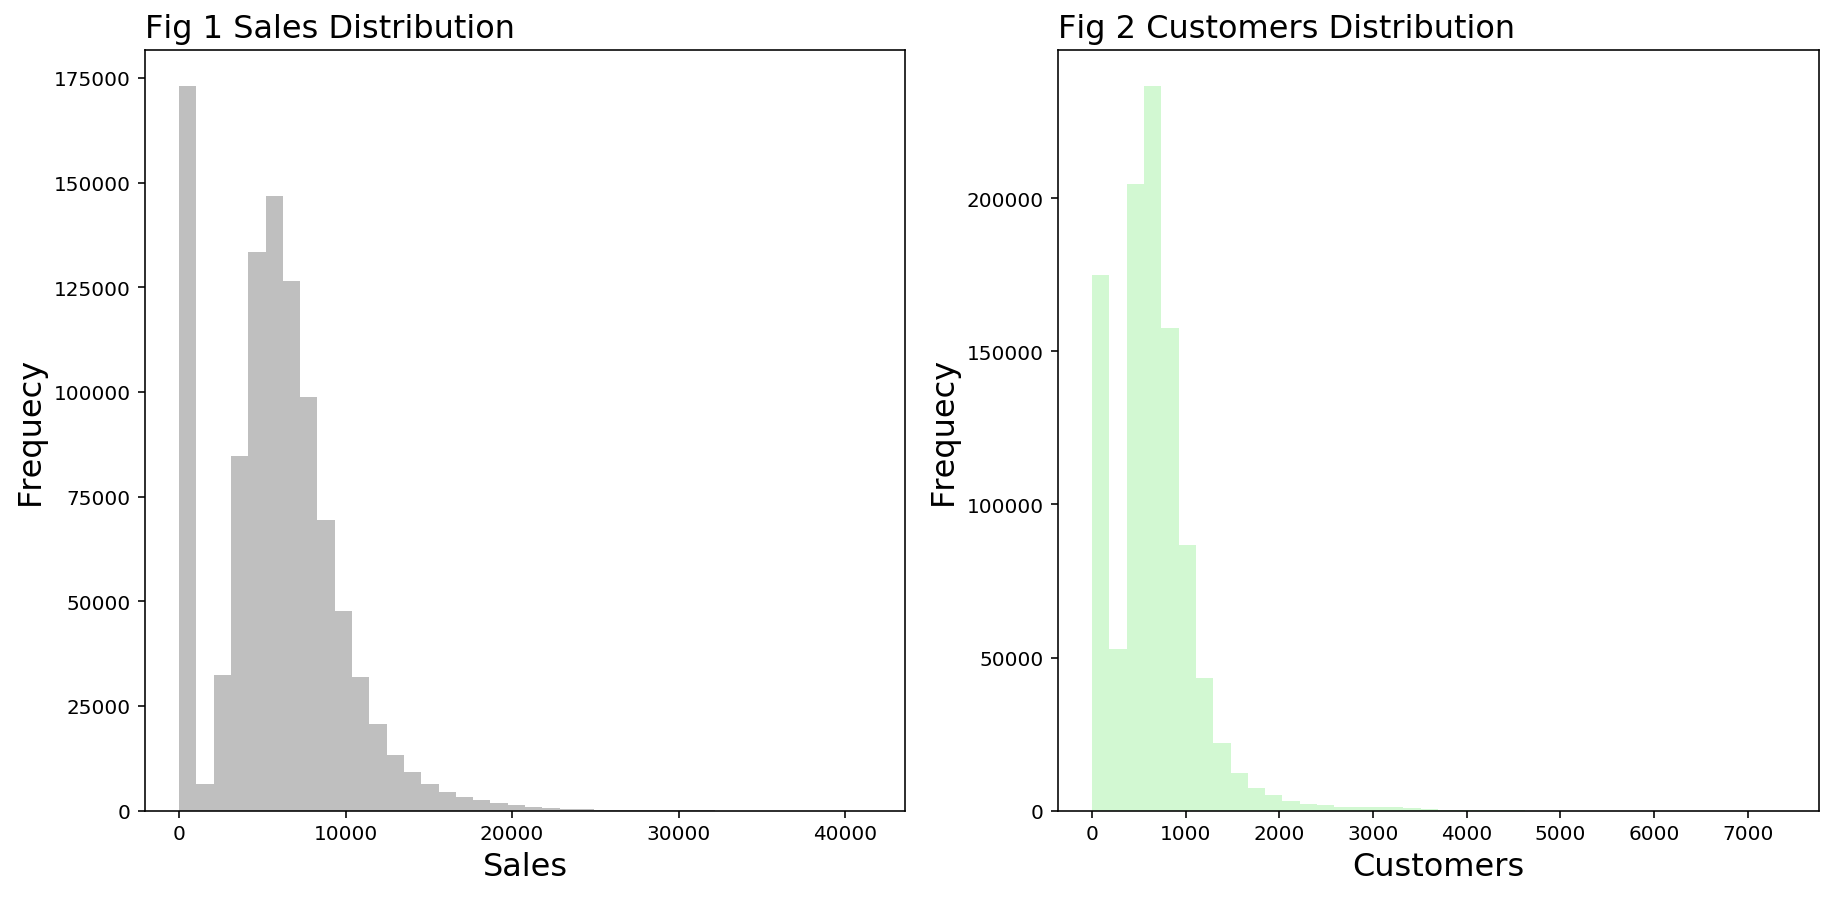

In [24]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.hist(data["Sales"], bins=40, color="grey", alpha=0.5)
plt.title("Fig 1 Sales Distribution", loc="left", fontsize=16)
plt.xlabel("Sales", fontsize=16)
plt.ylabel("Frequecy", fontsize=16)

plt.subplot(122)
plt.hist(data["Customers"], bins=40, color="lightgreen", alpha=0.4)
plt.title("Fig 2 Customers Distribution", loc="left", fontsize=16)
plt.xlabel("Customers", fontsize=16)
plt.ylabel("Frequecy", fontsize=16)
plt.show()

In [29]:
# drop the outlier, extreme value
outlier_index = [data["Sales"].idxmax(), data["Customers"].idxmax()]
clean_outlier_data = data.drop(axis=0, index=outlier_index[0])

In [26]:
from statsmodels.regression.linear_model import OLS

In [31]:
model = OLS(clean_outlier_data["Sales"], clean_outlier_data["Customers"])
result = model.fit()
print(result.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.930        
Dependent Variable: Sales            AIC:                18173504.6382
Date:               2018-06-24 18:21 BIC:                18173516.4707
No. Observations:   1017208          Log-Likelihood:     -9.0868e+06  
Df Model:           1                F-statistic:        1.355e+07    
Df Residuals:       1017207          Prob (F-statistic): 0.00         
R-squared:          0.930            Scale:              3.3625e+06   
------------------------------------------------------------------------
                Coef.    Std.Err.       t       P>|t|    [0.025   0.975]
------------------------------------------------------------------------
Customers       8.5237     0.0023   3681.1981   0.0000   8.5192   8.5283
----------------------------------------------------------------------
Omnibus:             481000.264     Durbin-Watson:        1.714       
Prob(Omnibus):    

<Figure size 1080x504 with 0 Axes>

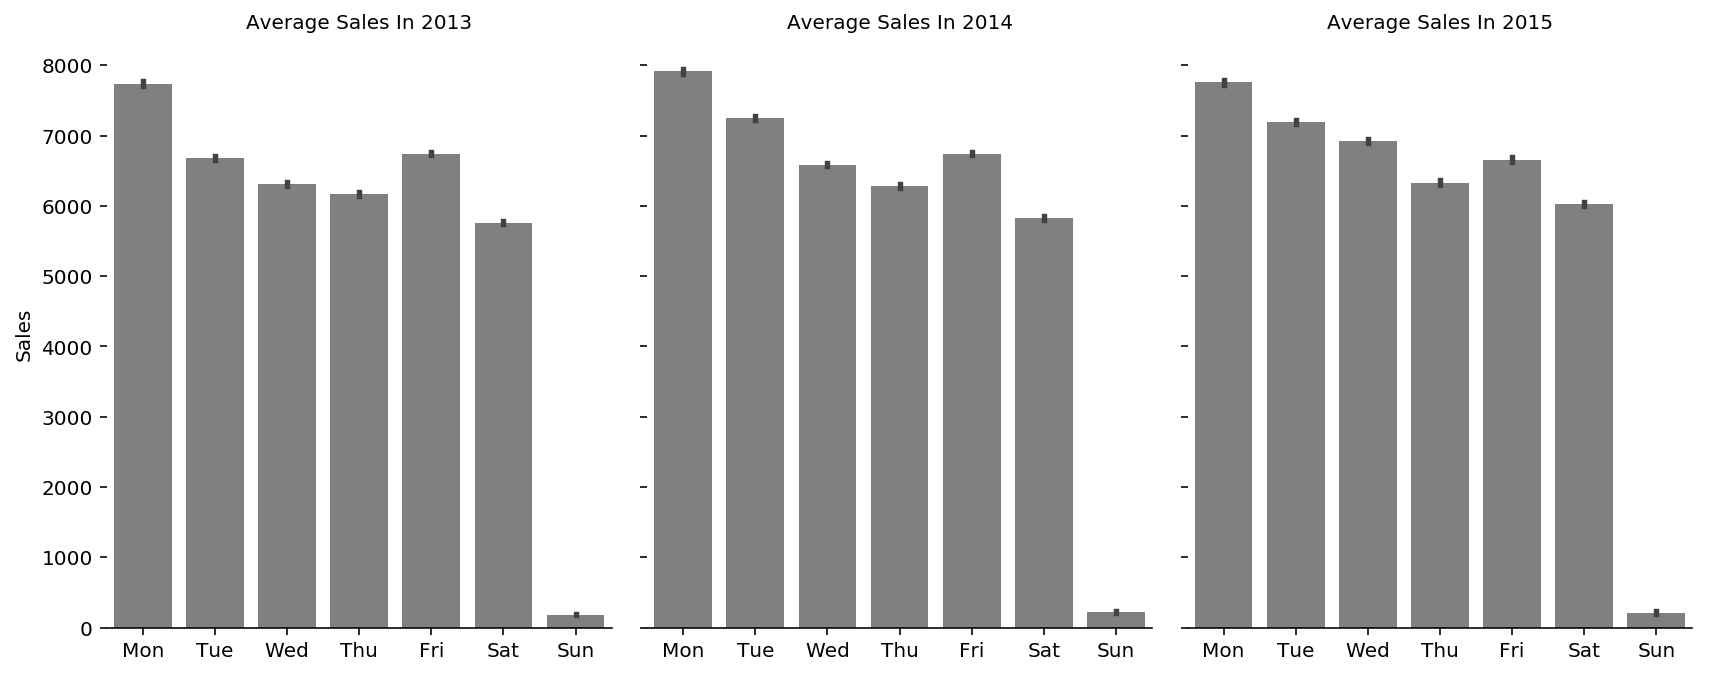

In [32]:
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="DayOfWeek", y="Sales",col="OpenYear", 
                    data=clean_outlier_data, aspect=0.8,
                    size=5, kind="bar", sharey=True, color="grey")
g.set_axis_labels("", "Sales")
g.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]),
g.set_titles("Average Sales In {col_name}")
g.despine(left=True)

plt.show()

<Figure size 1080x504 with 0 Axes>

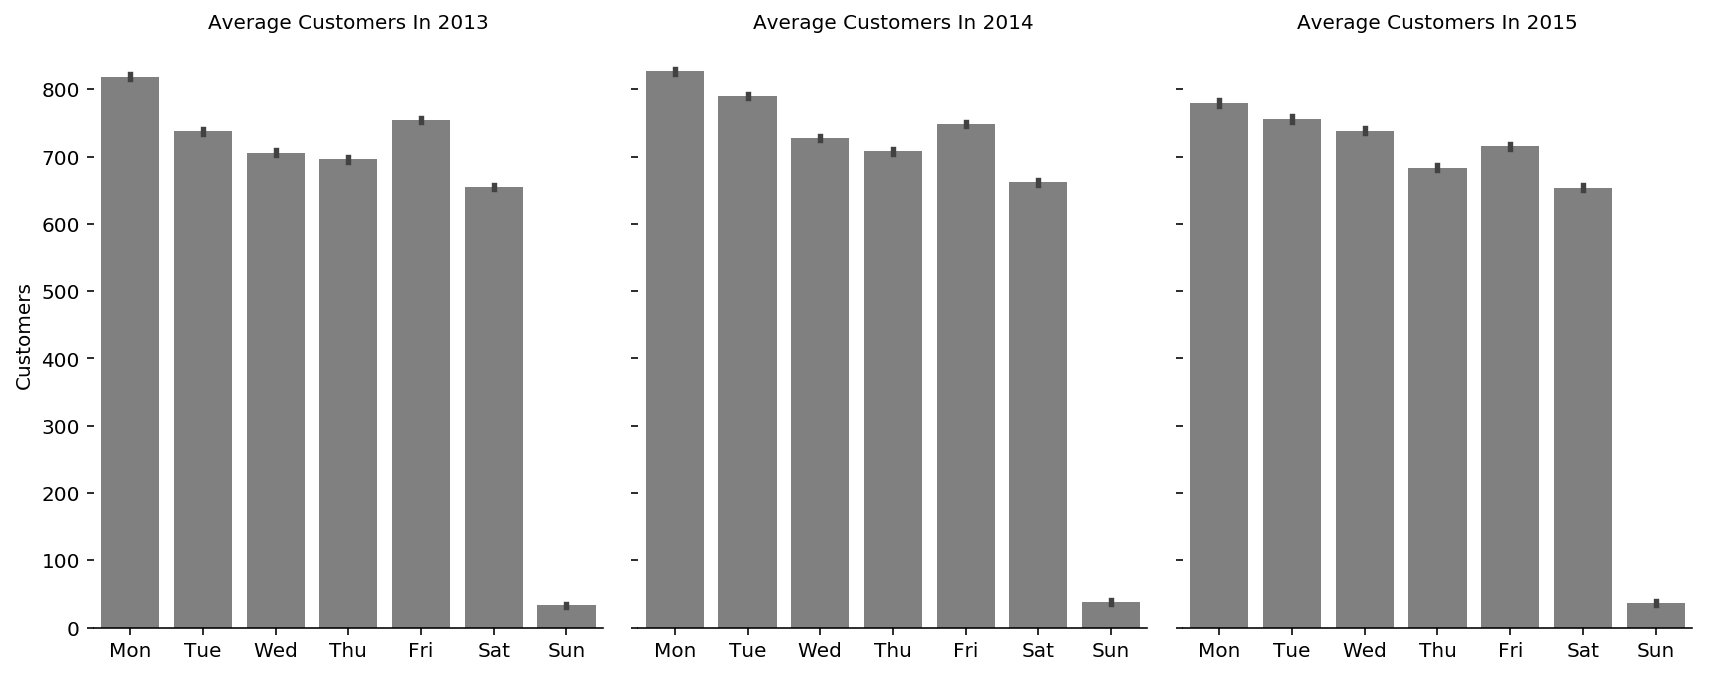

In [33]:
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="DayOfWeek", y="Customers",col="OpenYear", 
                    data=clean_outlier_data, aspect=0.8,
                    size=5, kind="bar", sharey=True, color="grey")
g.set_axis_labels("", "Customers")
g.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]),
g.set_titles("Average Customers In {col_name}")
g.despine(left=True)

plt.show()

<Figure size 1080x504 with 0 Axes>

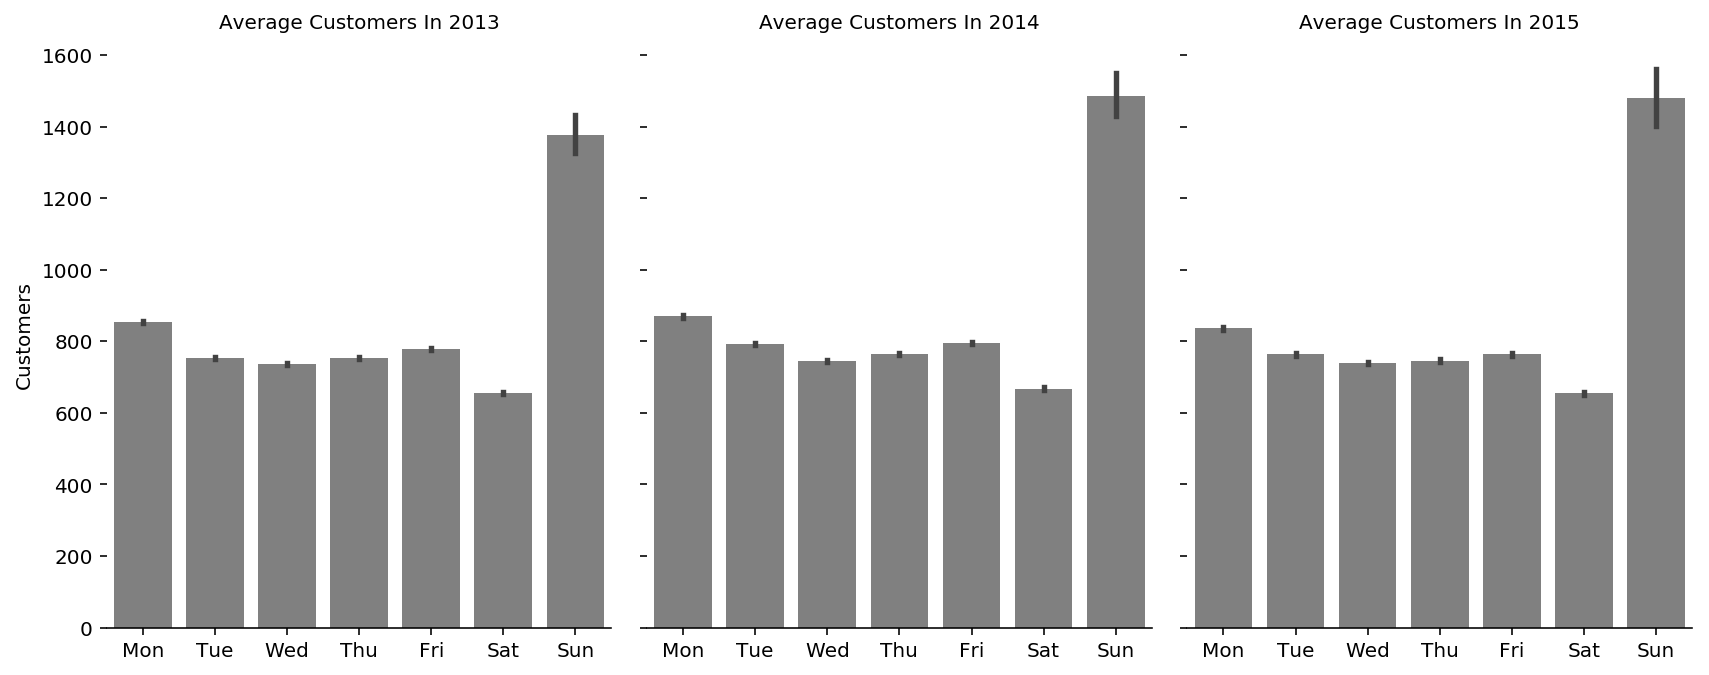

In [34]:
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="DayOfWeek", y="Customers",col="OpenYear", 
                    data=clean_outlier_data[clean_outlier_data["Open"]==1], aspect=0.8,
                    size=5, kind="bar", sharey=True, color="grey")
g.set_axis_labels("", "Customers")
g.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]),
g.set_titles("Average Customers In {col_name}")
g.despine(left=True)

plt.show()

<Figure size 1080x504 with 0 Axes>

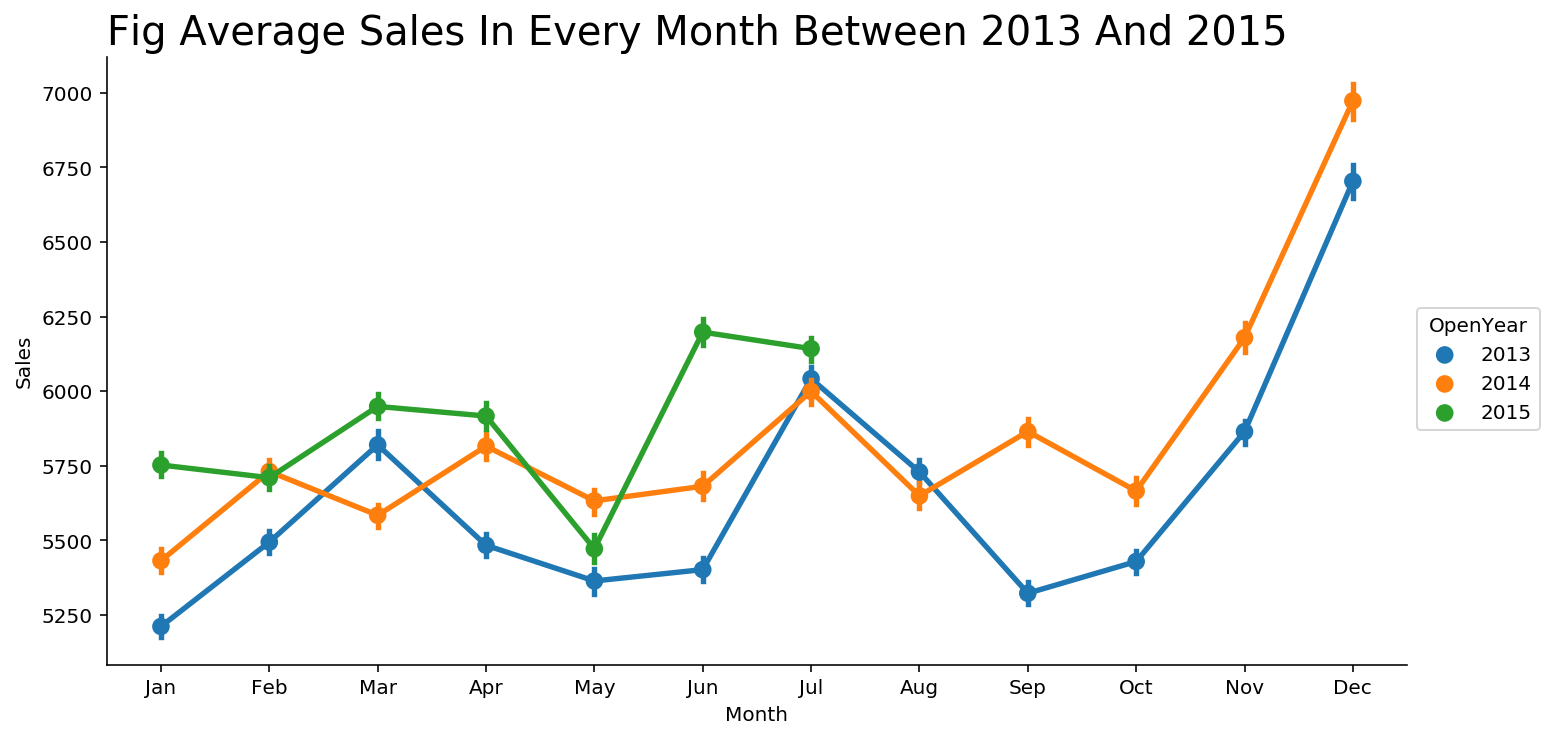

In [35]:
# 分析每月的营业额和客户数量
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="OpenMonth", y="Sales", hue="OpenYear", data=clean_outlier_data,size=5,aspect=2)
g.set_axis_labels("Month", "Sales")
g.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Fig Average Sales In Every Month Between 2013 And 2015", loc="left", fontsize=20)
plt.show()

<Figure size 1080x504 with 0 Axes>

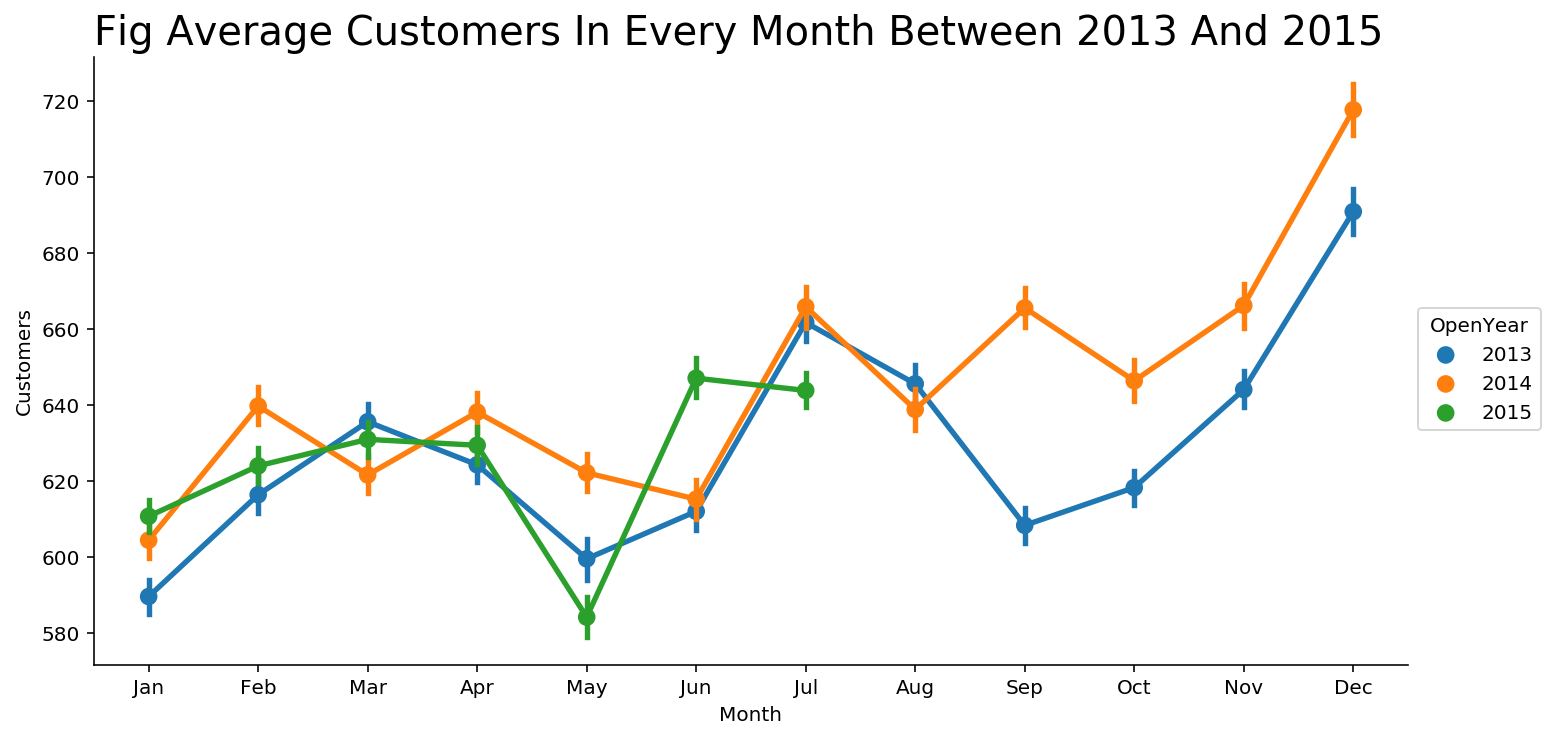

In [36]:
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="OpenMonth", y="Customers", hue="OpenYear", data=clean_outlier_data,size=5,aspect=2)
g.set_axis_labels("Month", "Customers")
g.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Fig Average Customers In Every Month Between 2013 And 2015", loc="left", fontsize=20)
plt.show()

Text(0,1,'Fig Promotion Affect Sales In Every Month')

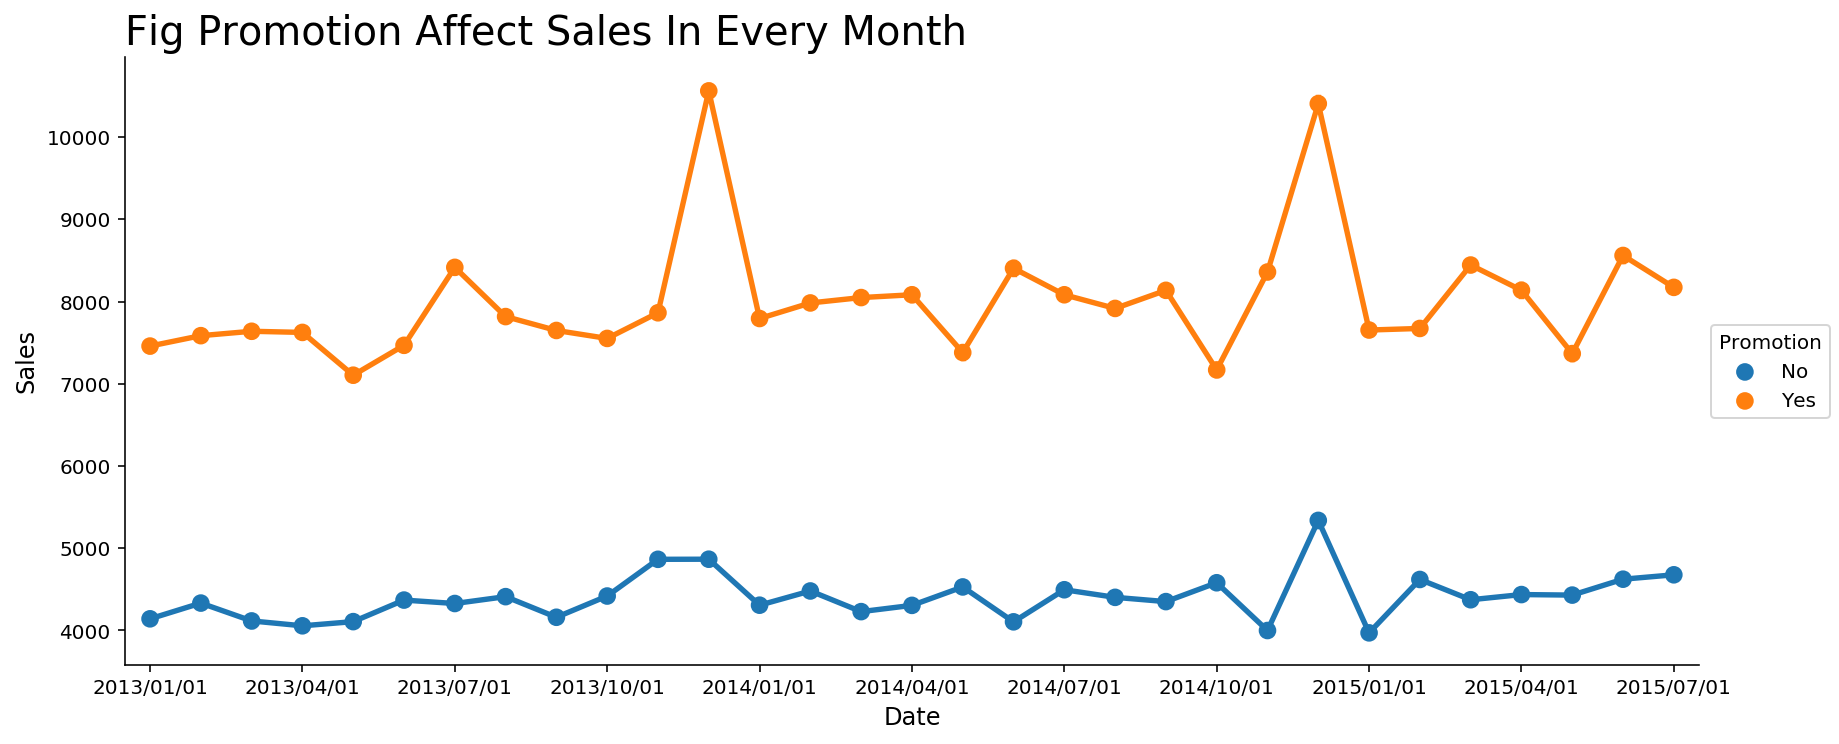

In [37]:
g = sns.factorplot(x="TemDate", y="Sales", hue="Promo", data=clean_outlier_data.sort_values(by="TemDate"), size=5, aspect=2.4, legend=False)
g.set_xticklabels(step=3)
g.set_xlabels("Date", fontsize=12)
g.set_ylabels("Sales", fontsize=12)
g.add_legend({"No":g._legend_data["0"], "Yes":g._legend_data["1"]}, title="Promotion")
plt.title("Fig Promotion Affect Sales In Every Month", loc="left", fontsize=20)

Text(0,1,'Fig Promotion Affect Customers In Every Month')

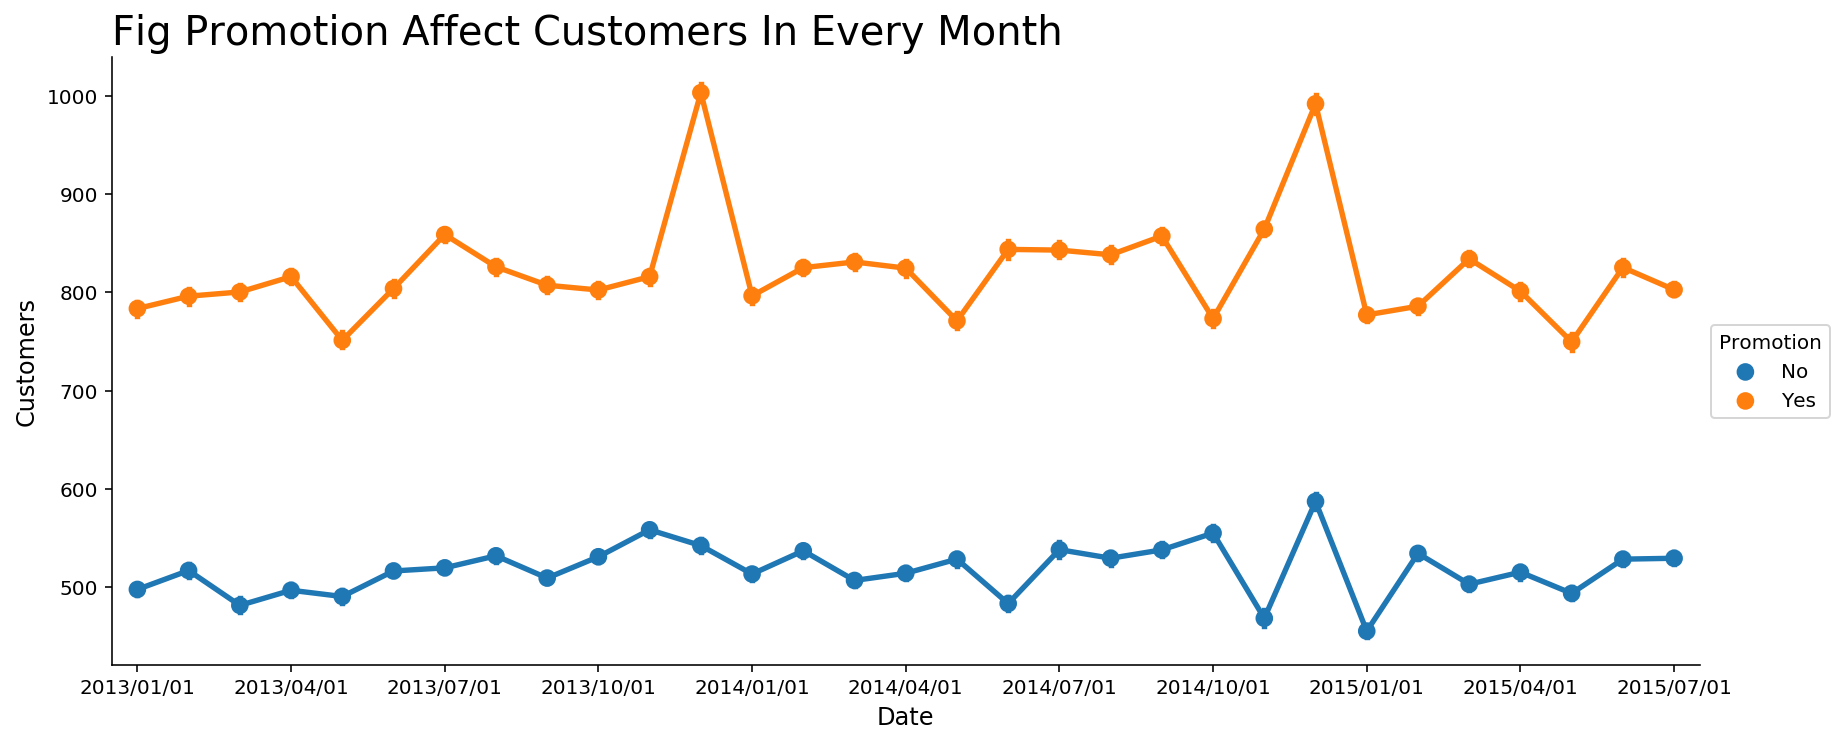

In [38]:
g = sns.factorplot(x="TemDate", y="Customers", hue="Promo", data=clean_outlier_data.sort_values(by="TemDate"), size=5, aspect=2.4, legend=False)
g.set_xticklabels(step=3)
g.set_xlabels("Date", fontsize=12)
g.set_ylabels("Customers", fontsize=12)
g.add_legend({"No":g._legend_data["0"], "Yes":g._legend_data["1"]}, title="Promotion")
plt.title("Fig Promotion Affect Customers In Every Month", loc="left", fontsize=20)

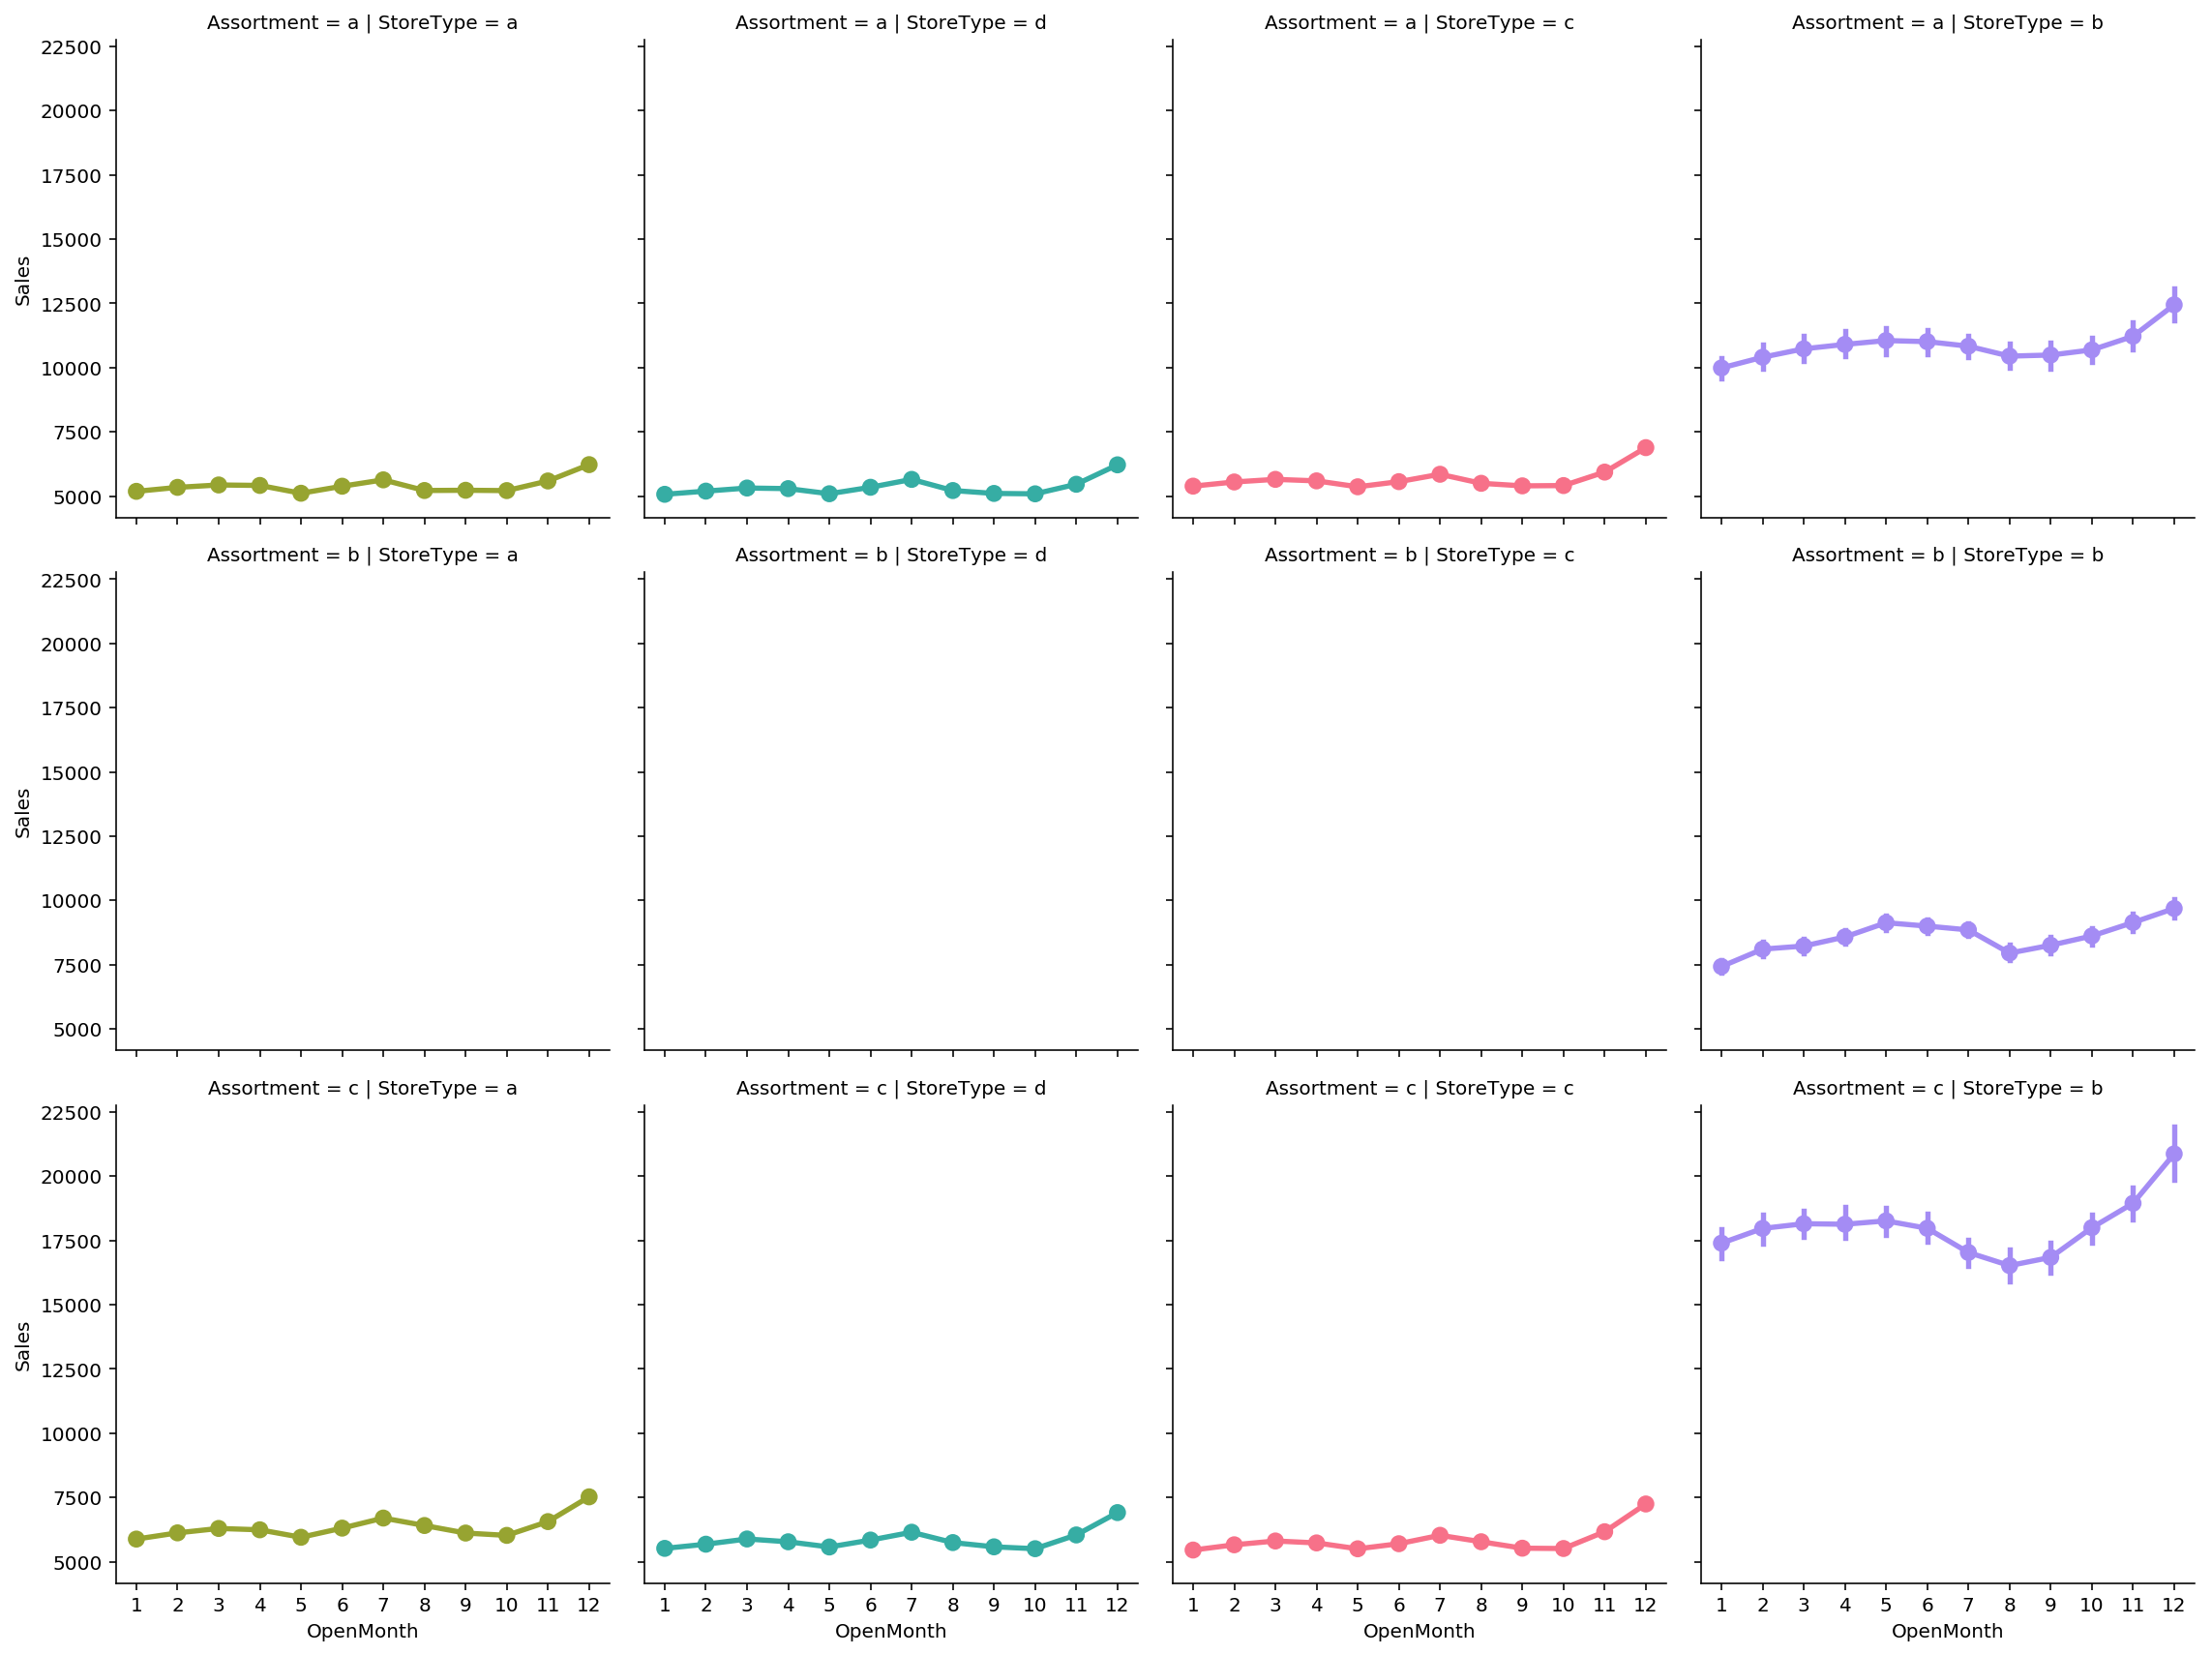

In [39]:
sns.factorplot(x="OpenMonth", y="Sales", hue="StoreType", data=clean_outlier_data,
              row="Assortment", col="StoreType", row_order=["a", "b", "c"],
              col_order=["a", "d", "c", "b"], palette=sns.color_palette("husl", 4))

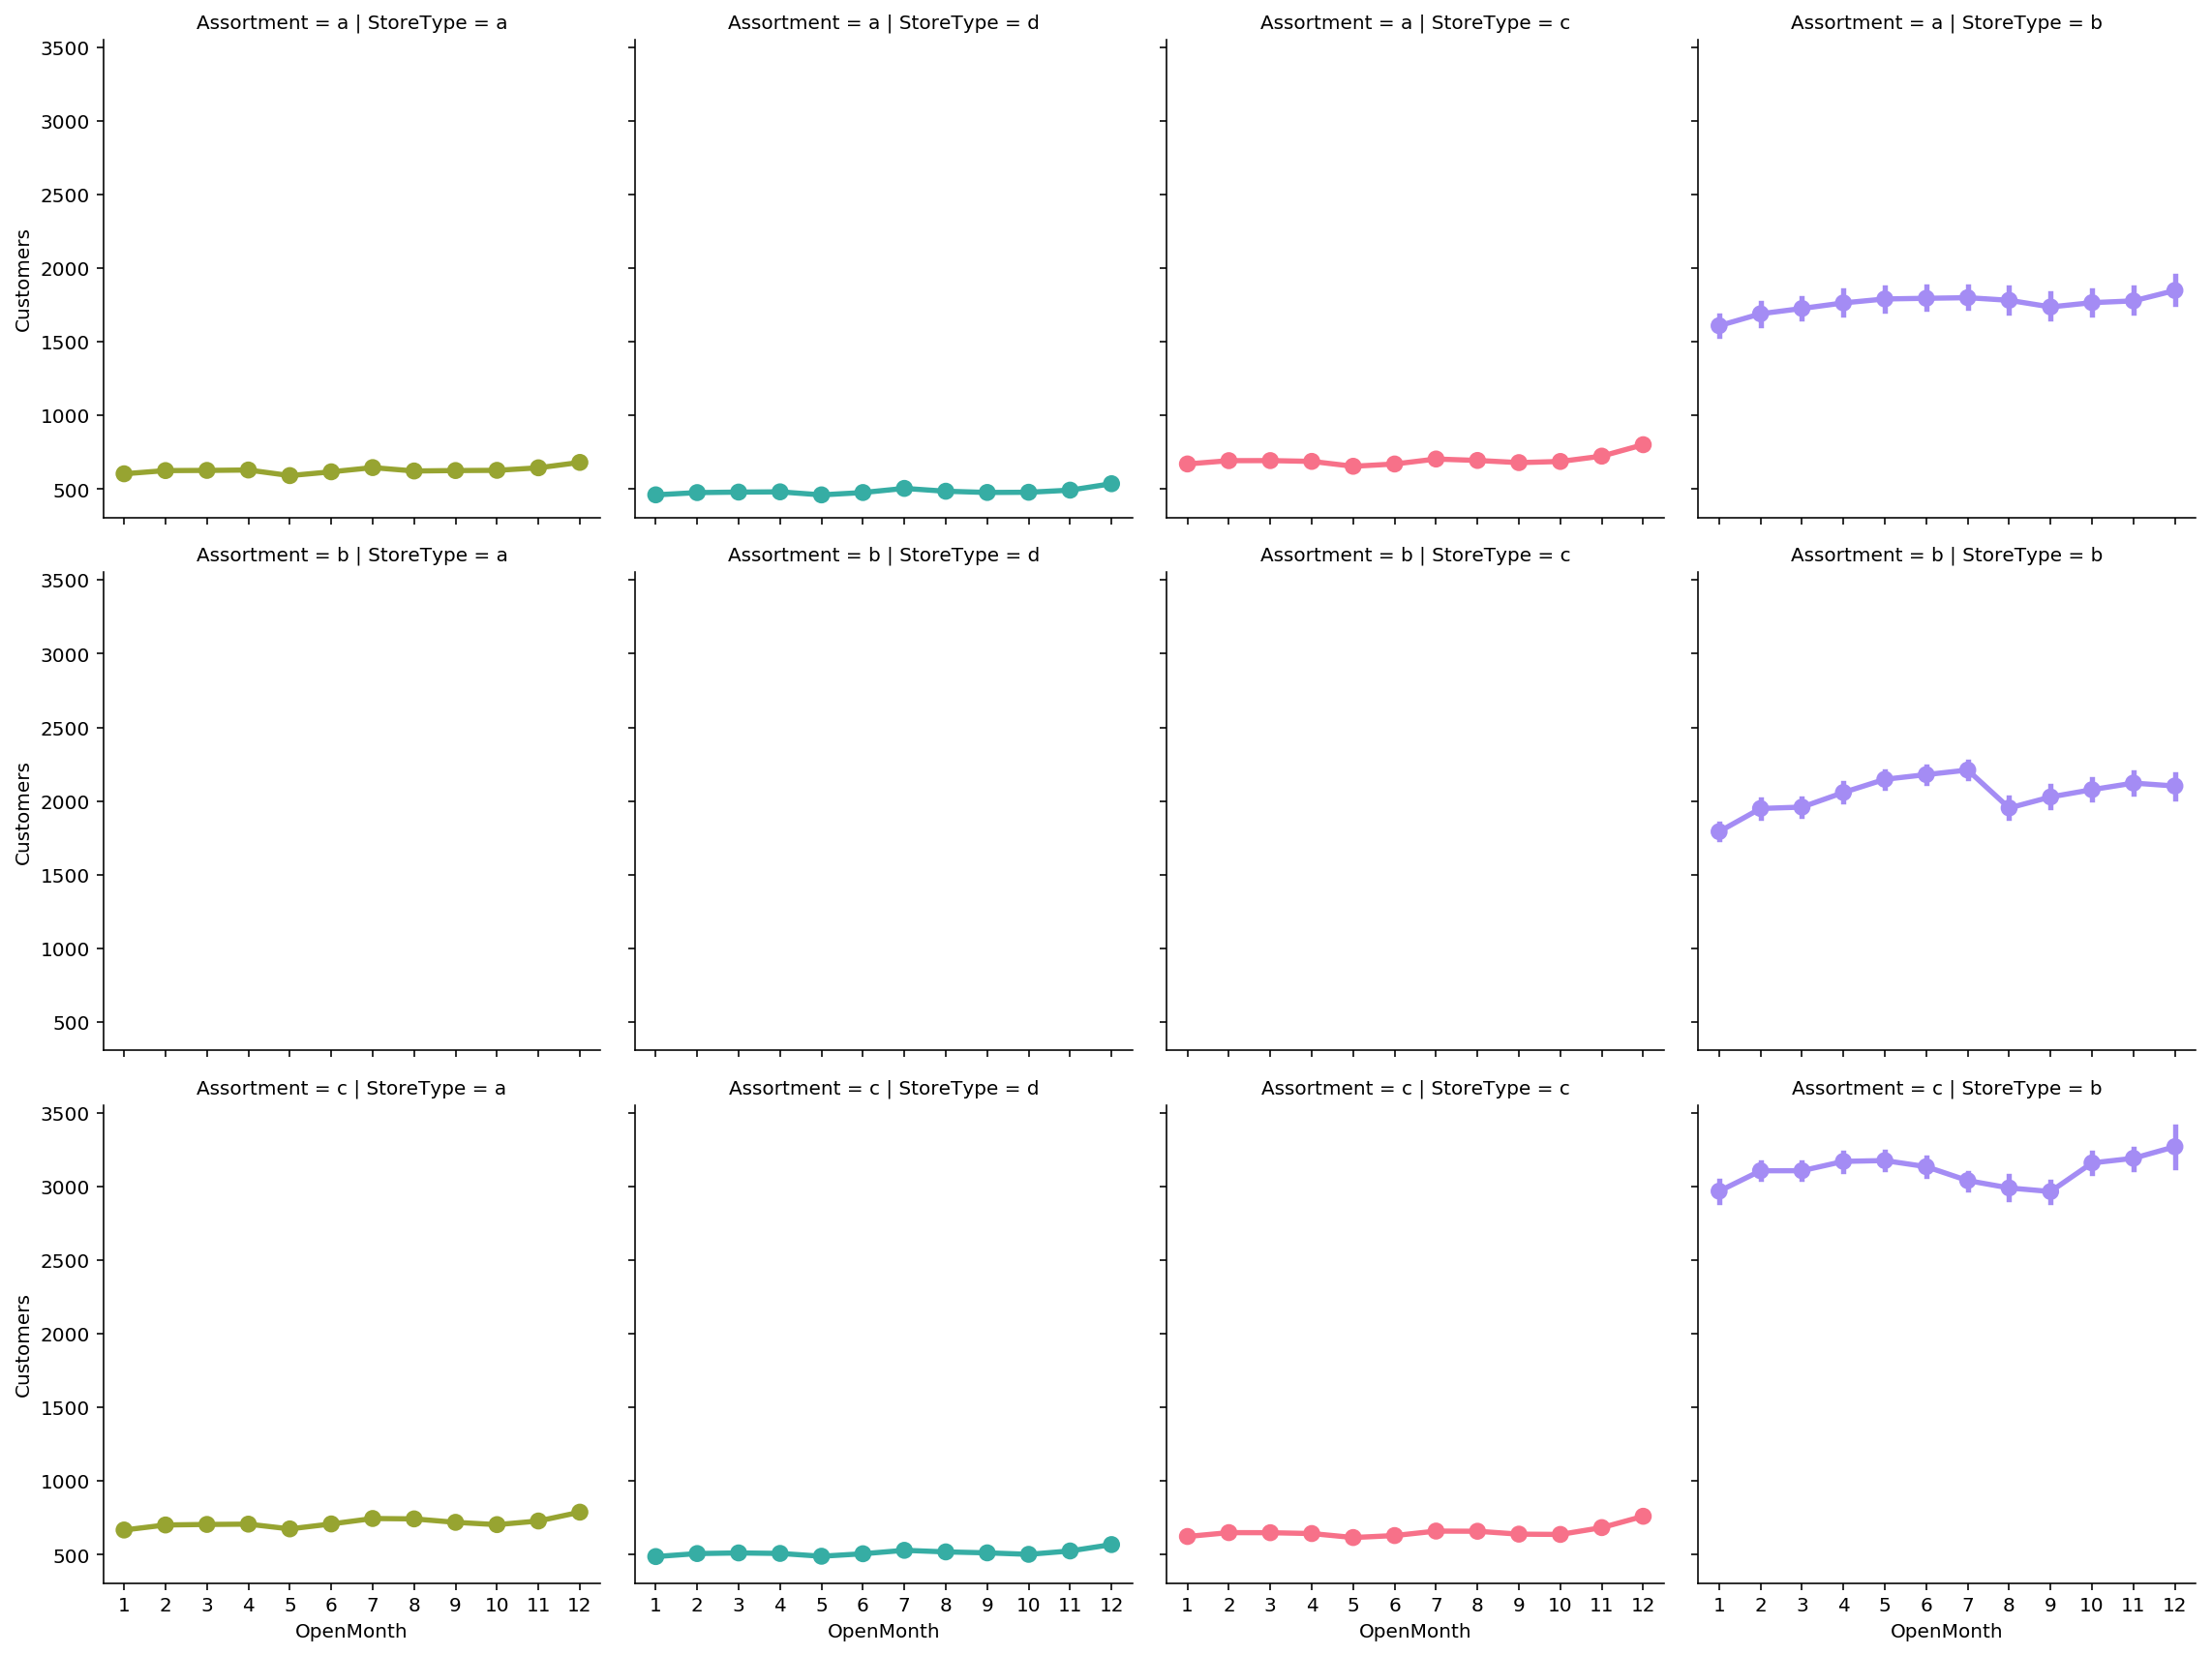

In [40]:
sns.factorplot(x="OpenMonth", y="Customers", hue="StoreType",data=clean_outlier_data,
              row="Assortment", col="StoreType", row_order=["a", "b", "c"],
              col_order=["a", "d", "c", "b"], palette=sns.color_palette("husl", 4))

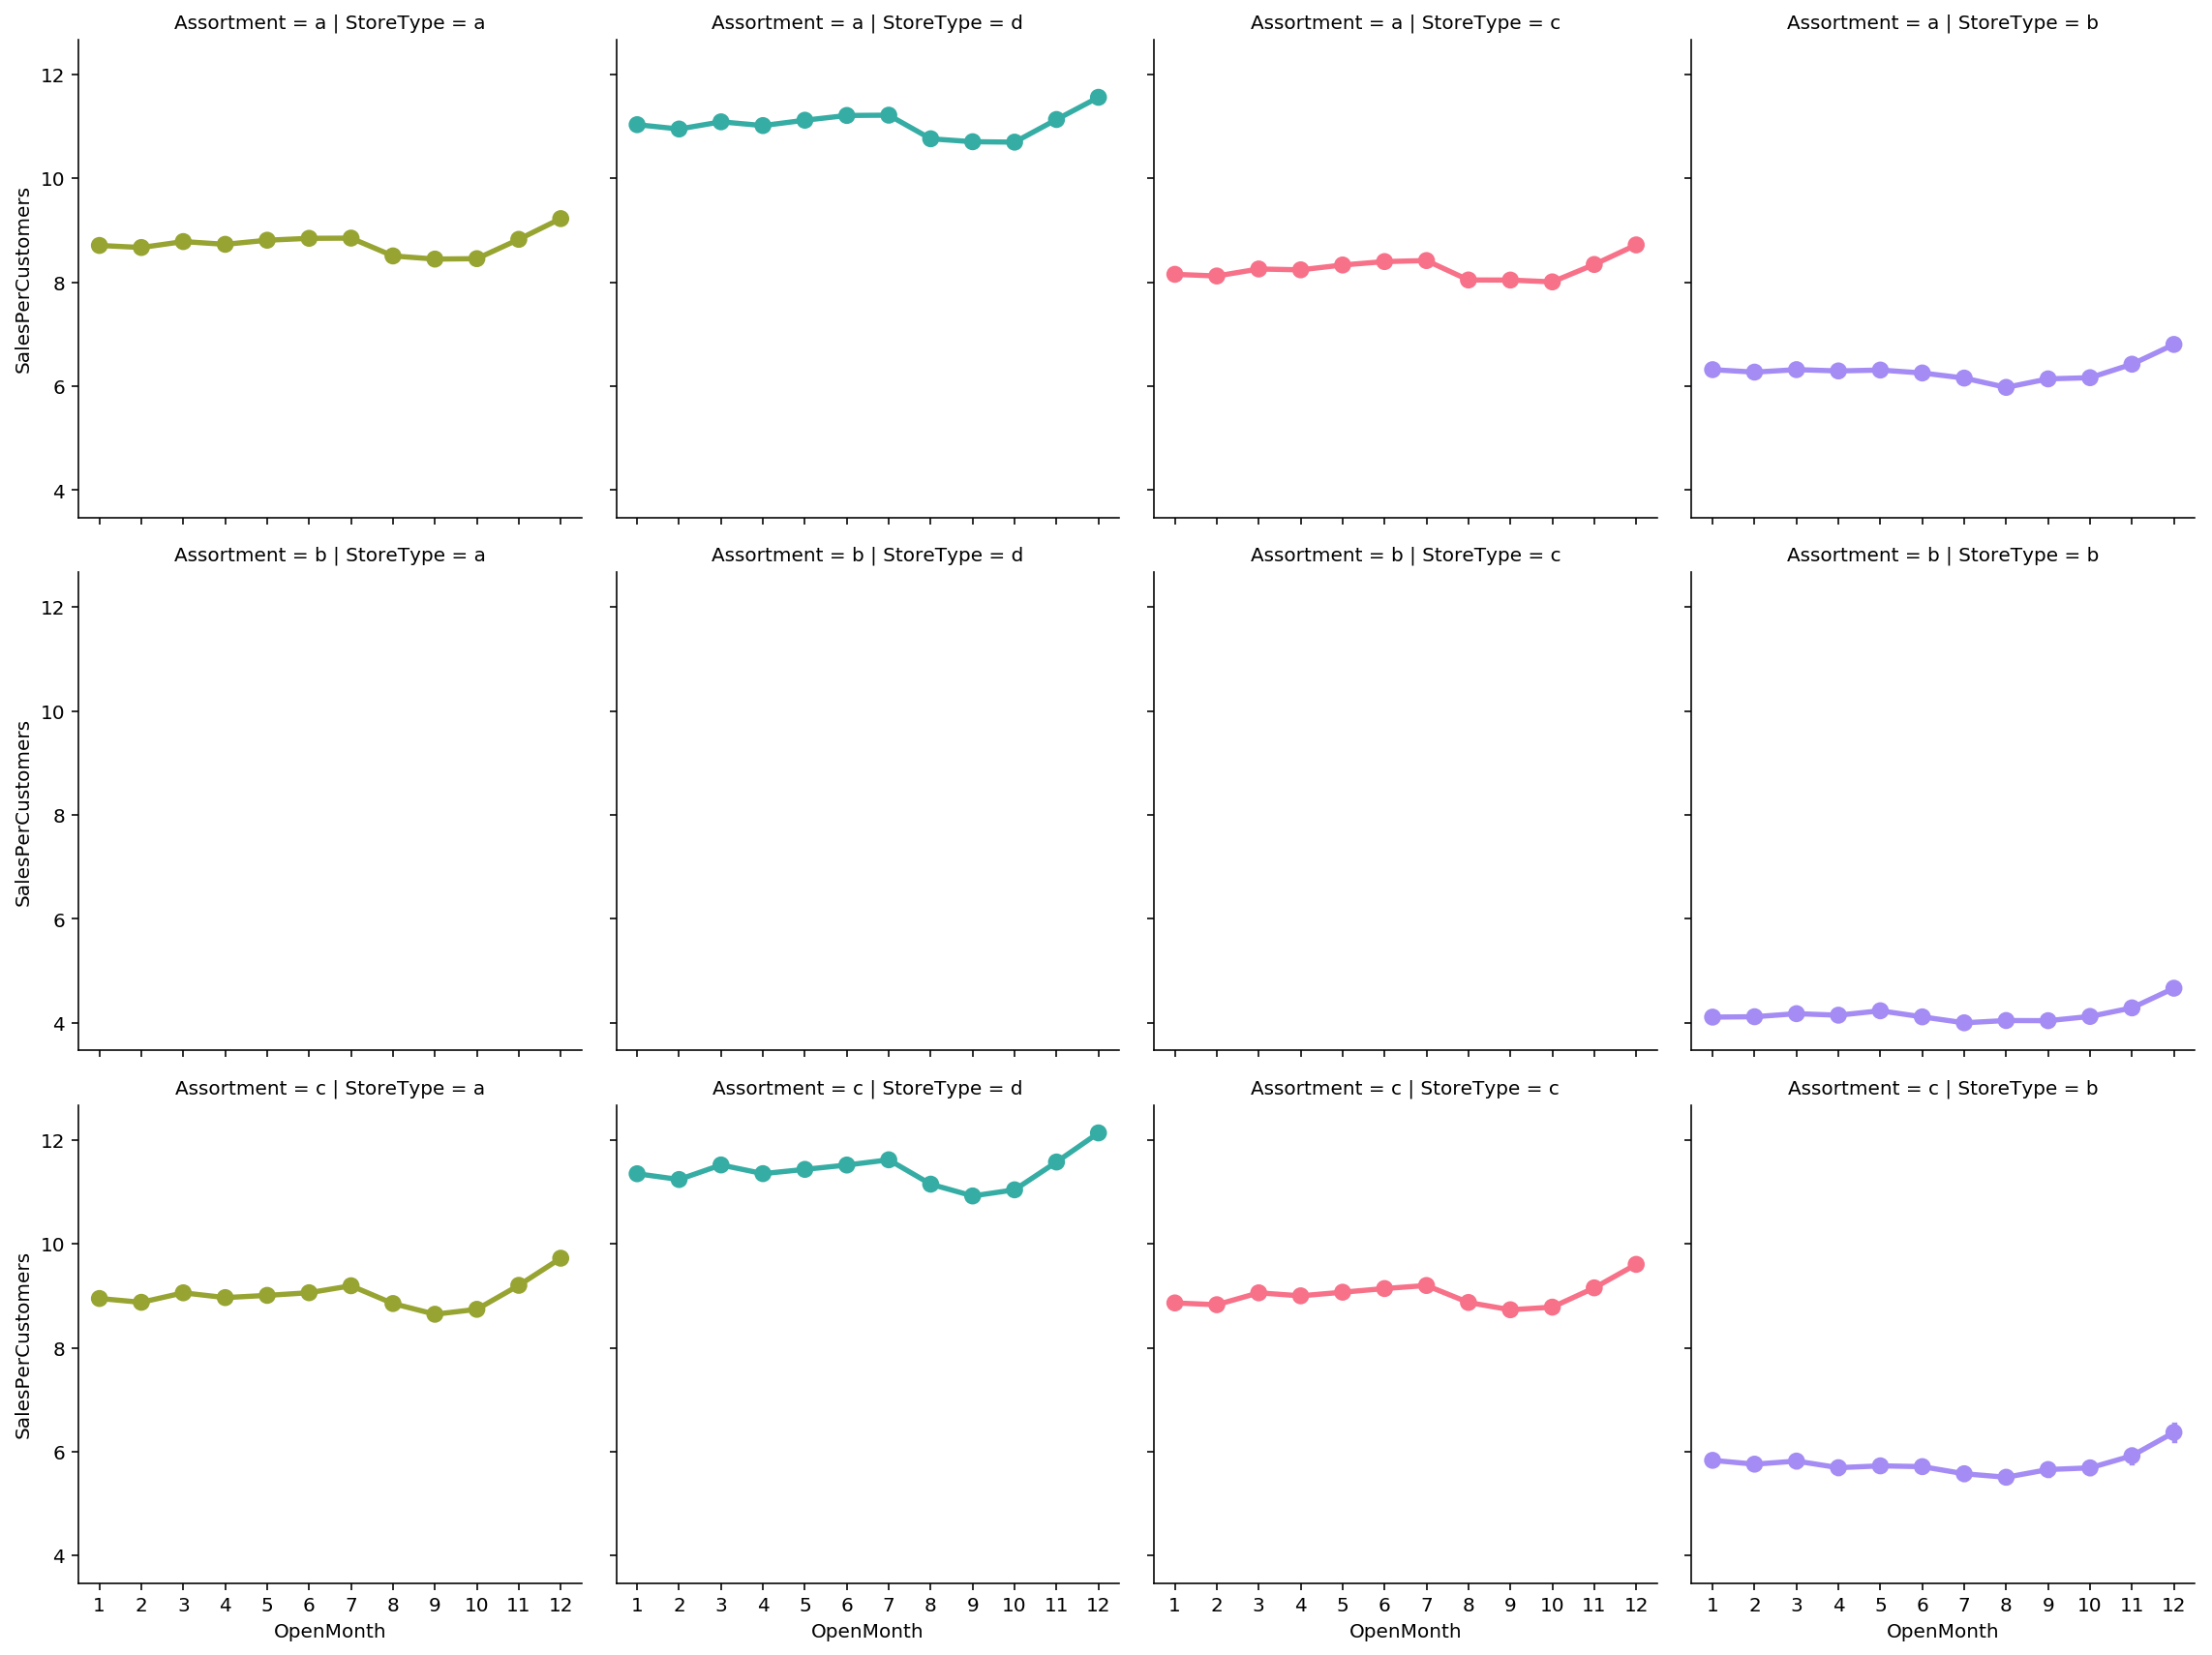

In [41]:
sns.factorplot(x="OpenMonth", y="SalesPerCustomers", hue="StoreType", data=clean_outlier_data,
              row="Assortment", col="StoreType", row_order=["a", "b", "c"],
              col_order=["a", "d", "c", "b"], palette=sns.color_palette("husl", 4))

### Create New DataSet

In [42]:
clean_outlier_data = data.drop(axis=0, index=outlier_index[0])
# drop the sales 0 with non_open
clean_outlier_data = clean_outlier_data.query("Sales != 0 & Open != 0")
clean_outlier_data["InPromo2"] = ((clean_outlier_data["Date"] >= clean_outlier_data["Promo2StartDate"]) & \
                                  (clean_outlier_data["Promo2"].apply(lambda x: True if x == 1 else False))).apply(lambda x: 1 if x == True else 0)

In [43]:
clean_outlier_data = pd.concat([clean_outlier_data, pd.get_dummies(clean_outlier_data["StateHoliday"], prefix="StateHoliday")], axis=1, sort=False)

clean_outlier_data = pd.concat([clean_outlier_data, pd.get_dummies(clean_outlier_data["StoreType"], prefix="StoreType")], sort=False, axis=1)

clean_outlier_data = pd.concat([clean_outlier_data, pd.get_dummies(clean_outlier_data["Assortment"], prefix="Assortment")], sort=False, axis=1)

In [44]:
clean_data = clean_outlier_data[["Sales", "Customers", "Open", "OpenYear", "OpenMonth", 
                                "OpenWeekOfYear", "CompetitionDistance", "CompetitionOpenMonths",
                                "InPromo2", "Promo2OpenMonths", "StateHoliday_a", "StateHoliday_b", 
                                "StateHoliday_c", "StoreType_a", "StoreType_b", "StoreType_c"]]